In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random

## Preprocessing

In [21]:
# Load and filter data
df = pd.read_csv('ratings.csv')
df = df[df['rating'] > 2]

# Filter users who have rated more than 10 movies
user_counts = df['userId'].value_counts()
valid_users = user_counts[user_counts > 10].index
df = df[df['userId'].isin(valid_users)]

# Split into train and test datasets
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

## Association Rule Mining

In [22]:
# Build train and test sets as dictionaries of user -> movie list
def build_user_movie_dict(data):
    return {user: list(group['movieId']) for user, group in data.groupby('userId')}

In [23]:
train_set = build_user_movie_dict(train_data)
test_set = build_user_movie_dict(test_data)

In [24]:
# Unique movies in the training set
movies_train_unique = list(set(movie for movies in train_set.values() for movie in movies))

In [25]:
# Support function
def support(movies, data_set):
    return len([user for user, user_movies in data_set.items() if all(movie in user_movies for movie in movies)]) / len(data_set)

In [26]:
# Generate frequent itemsets
def generate_frequent_itemsets(itemset_size, minsup, previous_itemsets):
    if itemset_size == 2:
        candidates = [(x, y) for x in previous_itemsets for y in previous_itemsets if x < y]
    else:
        candidates = [
            tuple(sorted(set(previous_itemsets[i]).union(previous_itemsets[j])))
            for i in range(len(previous_itemsets))
            for j in range(i + 1, len(previous_itemsets))
            if sorted(previous_itemsets[i][:-1]) == sorted(previous_itemsets[j][:-1])
        ]
    
    return [c for c in candidates if support(c, train_set) >= minsup]

In [27]:
# Generate association rules
def generate_association_rules(frequent_itemsets, minconf):
    rules = []
    for itemset in frequent_itemsets:
        itemset_support = support(itemset, train_set)
        for i in range(len(itemset)):
            antecedent = list(itemset[:i] + itemset[i+1:])
            confidence = itemset_support / support(antecedent, train_set)
            if confidence >= minconf:
                rules.append([antecedent, [itemset[i]], itemset_support, confidence])
    return rules

### 1. From the training set, extract the set of all association rules of form X → Y , where X contains a singlemovie and Y contains the set of movies from the training set by employing the apriori or FPgrowth approach. Set some minsup and minconf (e.g., 50 and 0.1 respectively)

In [28]:
# Set minimum support and confidence
minsup = 0.09
minconf = 0.1

In [29]:
# Generate frequent itemsets
l1_movies = [movie for movie in movies_train_unique if support([movie], train_set) >= minsup]
l2_movies = generate_frequent_itemsets(2, minsup, l1_movies)
l3_movies = generate_frequent_itemsets(3, minsup, l2_movies)

In [30]:
# Generate association rules
rules = generate_association_rules(l2_movies, minconf) + generate_association_rules(l3_movies, minconf)

### 2. Recommendation: 
Generate two sets of lists:
- The initial list includes the top 100 association rules, arranged in order of their support.
- The second list comprises the top 100 rules, prioritizing them according to confidence.
### Identify the rules that appear in both lists, and then arrange these shared rules based on their confidence score.

In [31]:
# Sort and select top rules by support and confidence
rules_by_sup = sorted(rules, key=lambda x: x[2], reverse=True)
rules_by_conf = sorted(rules, key=lambda x: x[3], reverse=True)

top_100_sup = rules_by_sup[:100]
top_100_conf = rules_by_conf[:100]

In [32]:
# Find common rules between top support and confidence
common_sup_conf_rules = [rule for rule in top_100_conf if rule in top_100_sup]

In [33]:
# Saving results
def save_rules_to_file(filename, rules):
    with open(filename, 'w') as f:
        for rule in rules:
            f.write(','.join(map(str, rule)) + '\n')

save_rules_to_file('29_top100RulesBySup.txt', top_100_sup)
save_rules_to_file('29_top100RulesByConf.txt', top_100_conf)

### 3. For each user in the test set, select association rules of the form X → Y , where X is the movie in the training set. Compute the average precision and average recall by varying the number of rules from 1 to 10 and plot the graphs.

In [34]:
# Precision and Recall evaluation
def evaluate_precision_recall(train_set, test_set, rules, k):
    precision_sum, recall_sum = 0, 0
    for user, train_movies in train_set.items():
        test_movies = test_set.get(user, [])
        recommendations = [asr[1][0] for movie in train_movies for asr in rules if movie == asr[0][0]][:k]
        hit_set = [m for m in recommendations if m in test_movies]

        recall = len(hit_set) / len(test_movies) if test_movies else 0
        precision = len(hit_set) / len(recommendations) if recommendations else 0
        
        recall_sum += recall
        precision_sum += precision

    return precision_sum / len(train_set), recall_sum / len(train_set)

In [35]:
precision_avgs, recall_avgs = [], []
for k in range(1, 11):
    precision, recall = evaluate_precision_recall(train_set, test_set, rules, k)
    precision_avgs.append(precision)
    recall_avgs.append(recall)

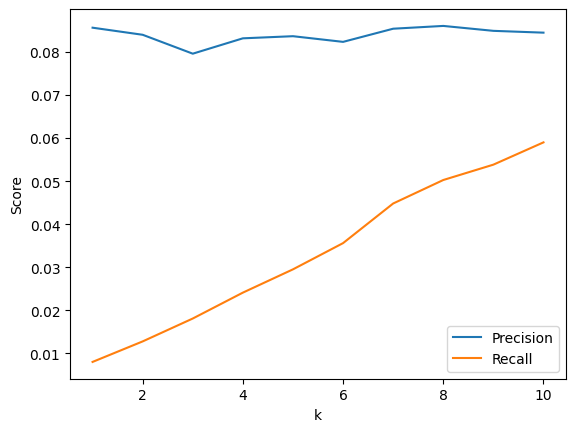

In [36]:
# Plot precision and recall vs k
x_vals = list(range(1, 11))
plt.plot(x_vals, precision_avgs, label='Precision')
plt.plot(x_vals, recall_avgs, label='Recall')
plt.xlabel('k')
plt.ylabel('Score')
plt.legend()
plt.show()

### 4. Take a sample example of users and their movie ratings from the test set and display precision and recall graphs

In [37]:
def plot_user_precision_recall(user_ids, train_set, test_set, rules):
    x_vals = list(range(1, 11))  # For k values from 1 to 10
    for user in user_ids:
        precision_avgs, recall_avgs = [], []
        for k in x_vals:
            precision, recall = evaluate_precision_recall({user: train_set[user]}, {user: test_set.get(user, [])}, rules, k)
            precision_avgs.append(precision)
            recall_avgs.append(recall)

        plt.plot(x_vals, precision_avgs, label=f'User {user} Precision')
        plt.plot(x_vals, recall_avgs, label=f'User {user} Recall')
        plt.xlabel('k')
        plt.ylabel('Score')
        plt.legend()
        plt.show()

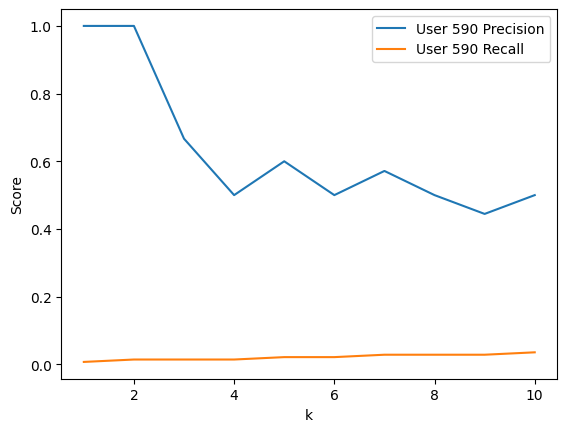

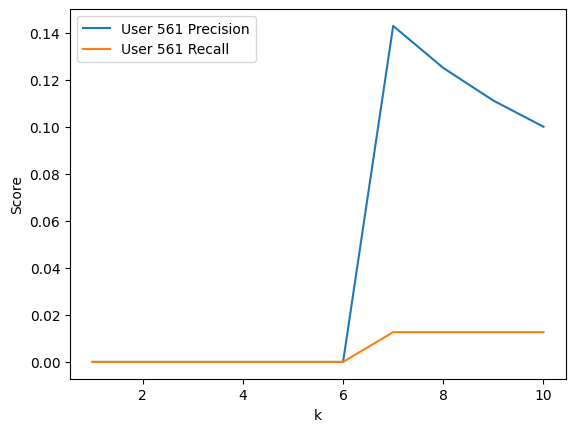

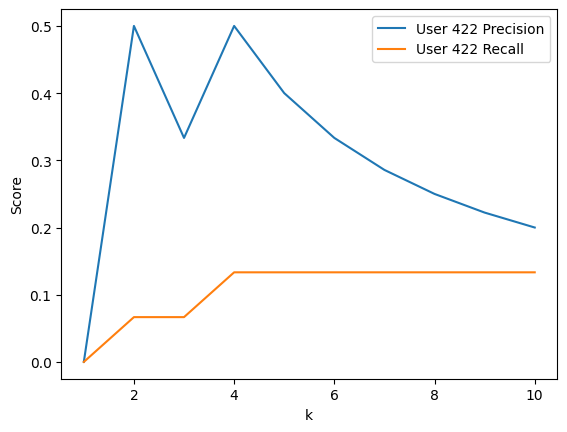

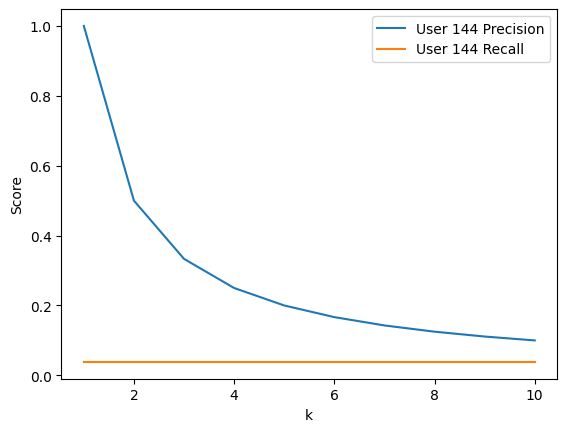

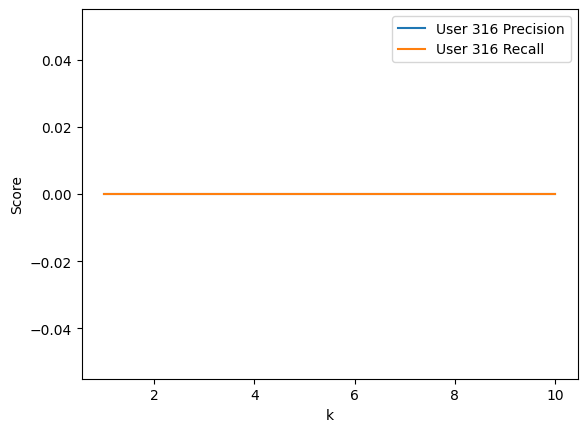

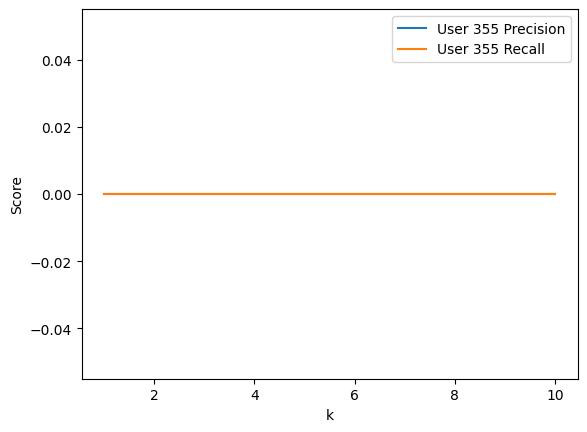

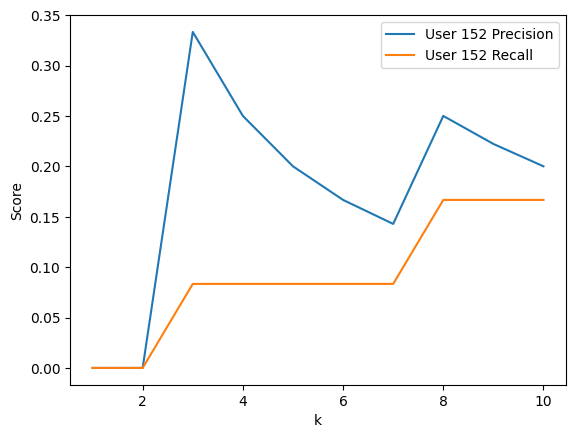

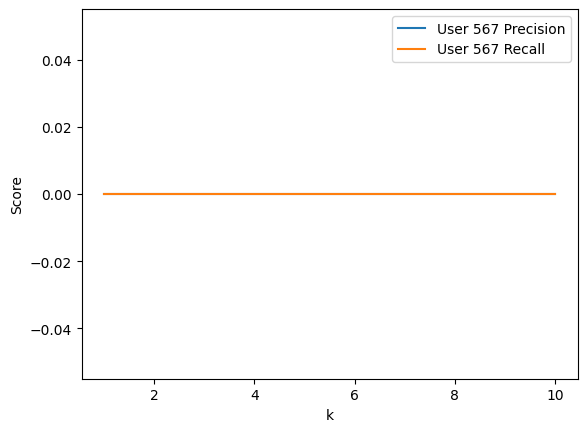

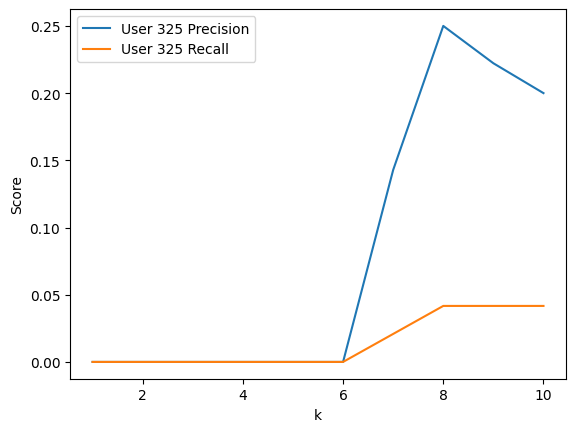

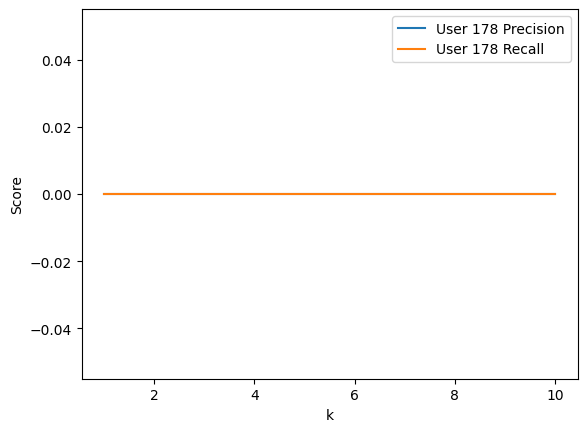

In [38]:
# Random sample of 10 users
sample_users = random.sample(list(test_set.keys()), 10)
plot_user_precision_recall(sample_users, train_set, test_set, rules)